# Maximum Likelihood vs CDF Fitting of Samples for Estimation of Distributions

In [133]:
from matplotlib import pyplot as plot
from random import uniform
from scipy.optimize import curve_fit, fsolve
from sympy import Array, Product, Symbol, integrate, lambdify, log, prod, solve

from LocUtil import Grid1, SetSeed
from LocMath import RandLog

In [103]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101

In [104]:
xSym = Symbol('x')

aSym = Symbol('a')
bSym = Symbol('b')

## Setup a Simple Distribution

In [105]:
form = aSym * (1 - xSym) + bSym * xSym

In [106]:
area = integrate(form, (xSym,0,1))
bExp = solve(area - 1, bSym)[0]
bExp

2 - a

In [107]:
form.subs(bSym, bExp).simplify()

-2*a*x + a + 2*x

In [108]:
pdf = 2*(1 - aSym) * xSym + aSym
pdf

a + x*(2 - 2*a)

In [109]:
def PdfExp(a):
	return pdf.subs(aSym,a).simplify()

In [110]:
def PdfFunc(a):
	return lambdify(xSym, PdfExp(a))

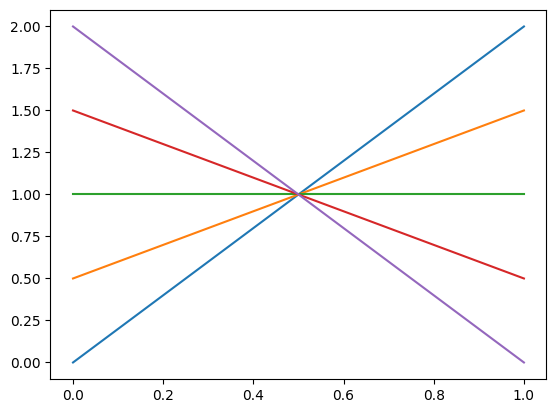

In [111]:
aL = Grid1(0,2,5)
xGrid = Grid1(0,1, nPlot)

for a in aL:
	func = PdfFunc(a)
	pdfGrid = [func(x) for x in xGrid]
	plot.plot(xGrid,pdfGrid)

In [112]:
cdf = integrate(PdfExp(aSym),xSym)
cdf

a*x + x**2*(1 - a)

In [113]:
def CdfFunc(a):
	return lambdify(xSym, cdf.subs(aSym, a).simplify())

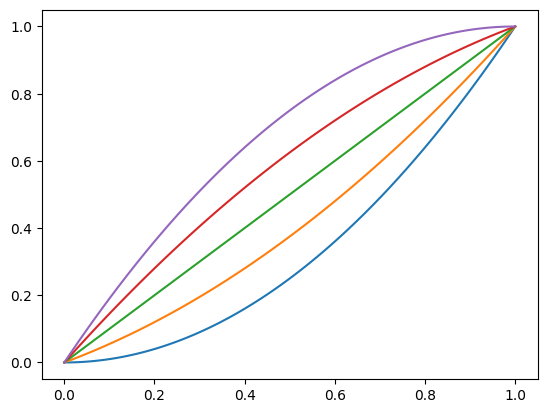

In [114]:
for a in aL:
	func = CdfFunc(a)
	cdfGrid = [func(x) for x in xGrid]
	plot.plot(xGrid,cdfGrid)

In [115]:
ySym = Symbol('y')
temp = solve(cdf - ySym, xSym)
temp

[(a - sqrt(a**2 - 4*a*y + 4*y))/(2*(a - 1)),
 (a + sqrt(a**2 - 4*a*y + 4*y))/(2*(a - 1))]

In [116]:
invCdf = temp[0]
invCdf

(a - sqrt(a**2 - 4*a*y + 4*y))/(2*(a - 1))

There is a removable singularity at a = 1 ... need a library function for dealing with removable 
singularities.  Would need to specify the required accuracy at the transition.

In [117]:
approxAt1 = invCdf.series(aSym,1).simplify().removeO()
approxAt1

y + (a - 1)**5*(21*(2*y - 1)**6 - 35*(2*y - 1)**4 + 15*(2*y - 1)**2 - 1)/32 + (a - 1)**4*(6*y + 7*(2*y - 1)**5 - 10*(2*y - 1)**3 - 3)/16 + (a - 1)**3*(5*(2*y - 1)**4 - 6*(2*y - 1)**2 + 1)/16 + (a - 1)**2*(-2*y + (2*y - 1)**3 + 1)/4 + (a - 1)*((2*y - 1)**2 - 1)/4

In [118]:
def InvCdfFunc(a):
	if abs(a - 1) < 0.01:
		result = approxAt1.subs(aSym,a)
	else:
		result = invCdf.subs(aSym, a).simplify()
	  
	return lambdify(ySym, result)

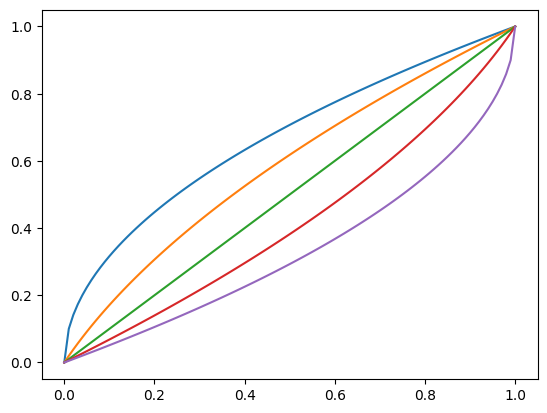

In [119]:
qGrid = Grid1(0,1, nPlot)

for a in aL:
	func = InvCdfFunc(a)
	invCdfGrid = [func(x) for x in xGrid]
	plot.plot(xGrid,invCdfGrid)

## CDF Fitting

In [120]:
seed = SetSeed(givenSeed,seedDig)
seed

552

In [121]:
def GenSamp(a, nSamp):
	sampCdf = [uniform(0,1) for _ in range(nSamp)]
	invCdfFunc = InvCdfFunc(a)
	x = [invCdfFunc(c) for c in sampCdf]
	
	return x

#### Consider a = 0

In [122]:
samp = GenSamp(0, nSamp)
sampSort = sorted(samp)
quant = [(k + 0.5) / nSamp for k in range(nSamp)]

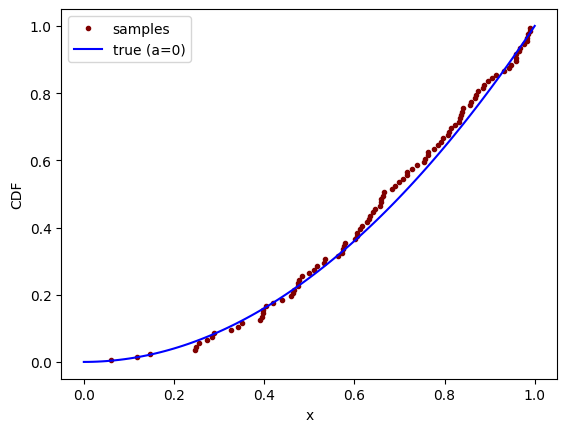

In [123]:
plot.plot(sampSort,quant, '.', c="maroon", label="samples")

cdfFunc = CdfFunc(0)
cdfGrid = [cdfFunc(x) for x in xGrid]
plot.plot(xGrid, cdfGrid, c="Blue", label='true (a=0)')

plot.xlabel('x')
plot.ylabel('CDF')
plot.legend()

In [124]:
xData = sampSort
yData = quant
f = lambdify([xSym,aSym], cdf)

In [125]:
optParam,_ = curve_fit(f,xData,yData)
fitA = optParam[0]

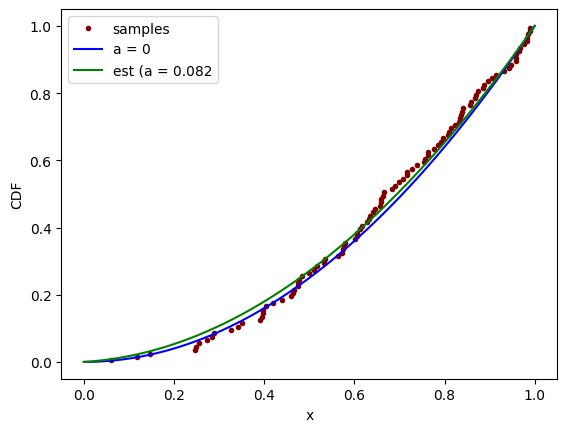

In [126]:
plot.plot(sampSort,quant, '.', c="maroon", label="samples")

cdfFunc = CdfFunc(0)
cdfGrid = [cdfFunc(x) for x in xGrid]
plot.plot(xGrid, cdfGrid, c="Blue", label='a = 0')

cdfFunc = CdfFunc(fitA)
cdfGrid = [cdfFunc(x) for x in xGrid]
plot.plot(xGrid, cdfGrid, c="Green", label=f'est (a = {fitA:.3f}')

plot.xlabel('x')
plot.ylabel('CDF')
plot.legend()

## Maximum Likelihood

In [127]:
derivLogLikeTerm = log(pdf).diff(aSym).simplify()

In [128]:
derivLogLikeTerm.subs(aSym,0)

(1 - 2*x)/(2*x)

In [129]:
derivLogLike = lambdify(aSym, sum(derivLogLikeTerm.subs(xSym, x) for x in samp))

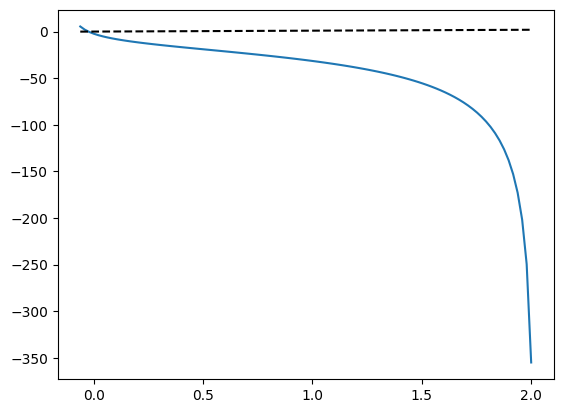

In [132]:
aMin = -min(samp)

aGrid = Grid1(aMin,2, nPlot)
yGrid = [derivLogLike(a) for a in aGrid]
plot.plot(aGrid, yGrid)

plot.plot((aMin,2), (0,2), '--', c='Black')

In [131]:
fsolve(derivLogLike, 1)

array([-0.02350315])